Ch1到Ch5 的总结<br>
目标：用两层神经网络实现

#### 第一步， 搭建网络架构

##### 导入

In [0]:
from collections import OrderedDict
import numpy as np

##### 使用到的层

###### Affine

In [0]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    
    self.x = None
    self.original_x_shape = None
    self.dW = None
    self.db = None
  def forward(self, x):
    
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.W) + self.b
    
    return out
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    dx = dx.reshape(*self.original_x_shape)
    return dx

###### ReLu

In [0]:
a = np.array([1,2,3,4,5,6])
a = a.reshape((2, 3))
print(a > 2)
c = a > 2
b = np.array([-1,-2,-3,5,6,2])
b = b.reshape((2,3))
print(b[c])

In [0]:
class Relu:
  def __init__(self):
    self.mask = None
  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0
    
    return out
  
  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

###### Softmax

In [0]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T
  x = x - np.max(x) # 溢出对策
  return np.exp(x) / np.sum(np.exp(x))

###### cross_entropy_error

In [0]:
a = np.array([[1,2,3],[0,5,6]])
print(a)
print(a.ndim)
print(a.argmax(axis=1))

In [0]:
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = t.reshape(1, y_size)
  if t.size == y.size:
    t = t.argmax(axis=1)
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

###### SoftmaxWithLoss

In [0]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
   
    if self.t.size == self.y.size:#如果大小相同
      dx = (self.y - self.t) / batch_size
    else:# 大小不同说明有batch
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size
    return dx

##### 计算梯度

In [0]:
def numerical_gradient(f, x):
  h = 1e-4
  grad = np.zeros_like(x)
  it = np.nditer(x , flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    idx = it.multi_index
    tmp_val = x[idx]
    x[idx] = float(tmp_val) + h
    fxh1 = f(x)
    
    x[idx] = tmp_val - h
    fxh2 = f(x)
    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp_val
    it.iternetx()
  return grad

##### Two Layer 类

In [0]:
class TwoLayer:
  def __init__(self, input_size, hidden_size, output_size,weight_init_std=0.01):
    
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] =  weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
    
    
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()
    
   
  def predict(self, x):
    for name, layer in self.layers.items():
      x = layer.forward(x)
    return x
  
  
  
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)
  
  
  
  def numerical_gradient(self, x, t):
    loss_W = lambda W: self.loss(x, t)
    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
    
    return grads
  
  def gradient(self, x, t):
    
    self.loss(x, t)
    
    dout = 1
    dout = self.lastLayer.backward(dout)
    
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    grads = {}
    grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
    
    return grads

#### 第二步，导入数据集 MNIST

##### 下载训练数据

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data',one_hot=True)

##### 读取训练数据

In [0]:
train_nums = mnist.train.num_examples
validation_nums = mnist.validation.num_examples
test_nums = mnist.test.num_examples

In [0]:
print(train_nums)
print(validation_nums)
print(test_nums)

In [0]:
train_data = mnist.train.images
val_data = mnist.validation.images
test_data = mnist.test.images

In [0]:
train_labels = mnist.train.labels

In [0]:
print(train_data.shape)
print(train_labels.shape)

#### 第三步，将数据导入网络

In [0]:
net = TwoLayer(input_size=784, hidden_size=50, output_size=10)

In [0]:
print(train_data.shape)

In [0]:
x = net.predict(train_data)
x.shape

In [0]:
print(train_labels.shape)

In [0]:
net.loss(train_data, train_labels)

In [0]:
net.gradient(train_data, train_labels)

In [0]:
train_loss_list = []
for i in range(1000):
  print("epoche:",i)
  grad = net.gradient(train_data, train_labels)
  for key in ('W1','b1','W2','b2'):
    net.params[key] -= 0.1 * grad[key]
  loss = net.loss(train_data, train_labels)
  train_loss_list.append(loss)

In [0]:
print(len(train_loss_list))

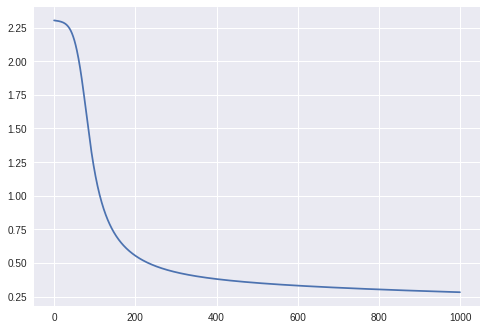

In [0]:
import matplotlib.pyplot as plt
x = np.arange(0, 1000)
plt.plot(x, train_loss_list)
plt.show()

#### 第四步 批处理

In [0]:
x_train = train_data
t_train = train_labels
net = TwoLayer(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = train_data.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []

iter_per_epoch = max(train_size / batch_size , 1)

for i in range(iters_num):
  print("Epoches:",i)
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  
  grad = net.gradient(x_batch, t_batch)
  
  for key in ('W1','b1','W2','b2'):
    net.params[key] -= 0.1 * grad[key]
    
  loss = net.loss(x_batch, t_batch)
  train_loss_list.append(loss)

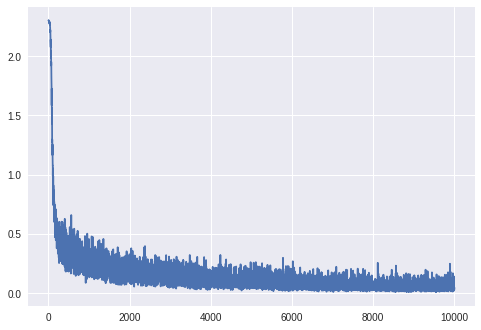

In [0]:
import matplotlib.pyplot as plt
x = np.arange(0, 10000)
plt.plot(x, train_loss_list)
plt.show()